# Energy Bins from SPAN


In [3]:
#!pip install wget
import wget
import cdflib
import numpy as np
from datetime import datetime
import os.path
import bisect
import matplotlib.pyplot as plt

from matplotlib import ticker, cm
import warnings 
warnings.filterwarnings("ignore")


from warnings import simplefilter 
simplefilter(action='ignore', category=DeprecationWarning)

## Data Download

In [4]:
year=2023
month=3
day=16

user_datetime = datetime(year,month,day)

def yyyymmdd(dt) : return f"{dt.year:04d}{dt.month:02d}{dt.day:02d}"

#Import from file directory
VDfile_directoryRemote = f'http://w3sweap.cfa.harvard.edu/pub/data/sci/sweap/spi/L2/spi_sf00/{user_datetime.year:04d}/{user_datetime.month:02d}/'
VDfile_filename = f'psp_swp_spi_sf00_L2_8Dx32Ex8A_{yyyymmdd(user_datetime)}_v04.cdf'

#check if file is already downloaded. If so, skip download. If not, download in local directory.
if os.path.isfile(VDfile_filename):
    print(f"File already exists in local directory - [{VDfile_filename}]")
    VDfile = VDfile_filename
else:
    print("File doesn't exist. Downloading ...")
    VDfile = wget.download(VDfile_directoryRemote + VDfile_filename)

File doesn't exist. Downloading ...


In [5]:
dat = cdflib.CDF(VDfile)

#print variable names in CDF files
print(dat._get_varnames())
cdf_VDfile=dat

#check variable formats in cdf file
print(cdf_VDfile)

([], ['Epoch', 'TIME', 'MET', 'APID', 'SEQN', 'SEQN_DELTA', 'SEQN_GROUP', 'PKT_SIZE', 'SOURCE_APID', 'SOURCE_HASH', 'COMPR_RATIO', 'NDAT', 'DATASIZE', 'LTCSNNNN_BITS', 'ARCH_BITS', 'MODE2_ORI', 'MODE2', 'F0', 'STATUS_BITS', 'PEAK_BIN', 'PRODUCT_BITS', 'NUM_TOTAL', 'NUM_ACCUM', 'TIME_TOTAL', 'TIME_ACCUM', 'CNTS', 'DATA', 'GAP', 'QUALITY_FLAG', 'EFLUX', 'ENERGY', 'THETA', 'PHI', 'ROTMAT_SC_INST'])


In [6]:
epoch_ns        = cdf_VDfile['Epoch']
theta           = cdf_VDfile['THETA']
phi             = cdf_VDfile['PHI']
energy          = cdf_VDfile['ENERGY']
eflux           = cdf_VDfile['EFLUX']
rotMat          = cdf_VDfile['ROTMAT_SC_INST']

In [7]:
#convert time
import datetime
datetime_t0 = datetime.datetime(2000, 1, 1, 12, 0, 0)
epoch = cdflib.cdfepoch.to_datetime(cdf_VDfile.varget('Epoch'))

hour = 14
minute = 10
second = 2

timeSlice  = datetime.datetime(year, month, day, hour, minute, second)
print('Desired timeslice:',timeSlice)

#find index for desired timeslice
tSliceIndex  = bisect.bisect_left(epoch,timeSlice)
print('time Index:',tSliceIndex)
print('Time of closest data point:',epoch[tSliceIndex])

Desired timeslice: 2023-03-16 14:10:02
time Index: 15836
Time of closest data point: 2023-03-16 14:10:03.823931


In [8]:
epochSlice  = epoch[tSliceIndex]
thetaSlice  = theta[tSliceIndex,:]
phiSlice    = phi[tSliceIndex,:]
energySlice = energy[tSliceIndex,:]
efluxSlice  = eflux[tSliceIndex,:]

In [9]:
thetaReshaped = thetaSlice.reshape((8,32,8))
phiReshaped = phiSlice.reshape((8,32,8))
energyReshaped = energySlice.reshape((8,32,8))
efluxReshaped = efluxSlice.reshape((8,32,8))

print(thetaReshaped.shape)

(8, 32, 8)


## Level 3 Data

24-Oct-23 21:52:11: The name psp_spi_VEL_INST is currently not in pytplot
24-Oct-23 21:52:11: The name psp_spi_VEL_INST is currently not in pytplot
24-Oct-23 21:52:11: Variable not found: psp_spi_VEL_INST


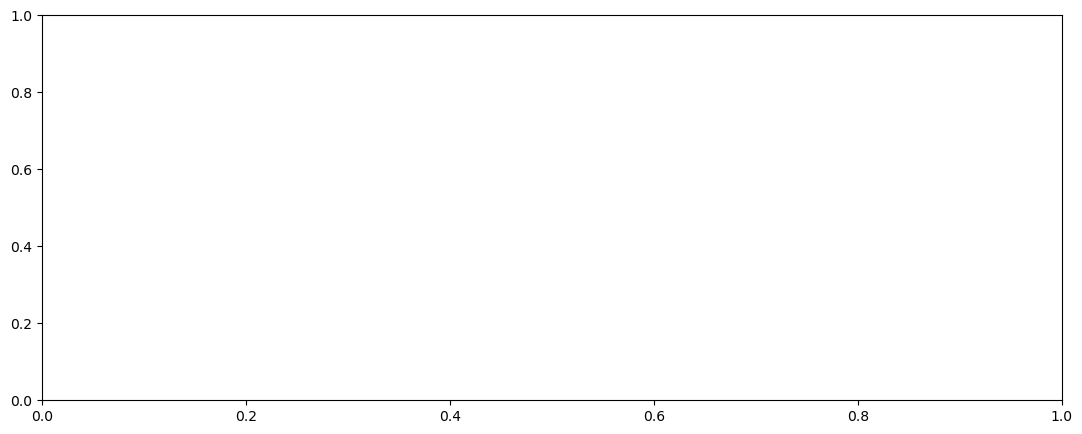

24-Oct-23 21:52:11: The name psp_spi_VEL_INST is currently not in pytplot


AttributeError: 'NoneType' object has no attribute 'y'

In [9]:
import pyspedas
from pytplot import tplot, get_data, cdf_to_tplot
time_range = ['2023-03-16/12:00', '2023-03-16/18:00']
# pvars = pyspedas.psp.spi(trange=time_range, datatype='sf00_l3_mom', 
#                             level='l3', time_clip=True)
tplot(['psp_spi_VEL_INST'])
vinst = get_data('psp_spi_VEL_INST')
vinstx = vinst.y[:, 0]
vinsty = vinst.y[:, 1]
vinstz = vinst.y[:, 2]
vxm, vym, vzm = np.nanmean(vinstx), np.nanmean(vinsty), np.nanmean(vinstz)
print(vxm, vym, vzm)

## Calculations

In [10]:
mass_p = 0.010438870      #proton mass in units eV/c^2 where c = 299792 km/s
charge_p = 1              #proton charge in units eV

#Define VDF
numberFlux = efluxReshaped/energyReshaped
vdf = numberFlux*(mass_p**2)/((2E-5)*energyReshaped)

#Convert to velocity units in each energy channel
vel = np.sqrt(2*charge_p*energyReshaped/mass_p)

In [11]:
vx = vel * np.cos(np.radians(phiReshaped)) * np.cos(np.radians(thetaReshaped))
vy = vel * np.sin(np.radians(phiReshaped)) * np.cos(np.radians(thetaReshaped))
vz = vel *                                   np.sin(np.radians(thetaReshaped))

In [ ]:
# for i in np.arange(0, 8):
#     for j in np.arange(0, 8):
#         for k in np.arange(0, 32):
#             plt.scatter(thetaReshaped[j][k][i], phiReshaped[j][k][i], c=energyReshaped[j][k][i], cmap='plasma', s=3)

In [14]:
### find mean speed from VDF
fvx = np.sum(vx * vdf, axis=(0,2)) / np.sum(vdf, axis=(0,2))
print(np.sum(vdf, axis=(0, 2)))

[      0.           0.           0.           0.           0.
       0.           0.           0.           0.           0.
       0.           0.           0.           0.        7022.8364
   60483.496   166806.16    594017.8    1458777.2    3269202.2
 4349240.     4636062.     3947438.     3408311.           0.
       0.           0.           0.           0.           0.
       0.           0.    ]


Text(0.5, 0.92, 'Mean Wind Speed[-247.74632, 125.36058, 31.24338]')

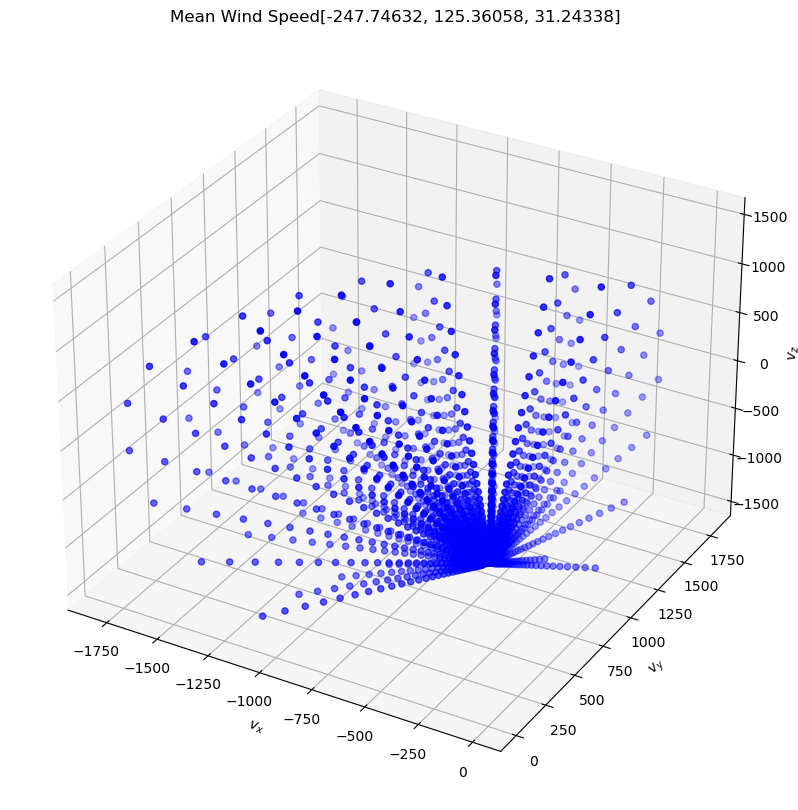

In [127]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np

# Create some sample data
vdf_allAngles = np.sum(vdf, axis=(0,2))
mean_vel = vel[0, :, 0][np.where(vdf_allAngles == np.nanmax(vdf_allAngles))[0]]

# Create a 3D plot
fig = plt.figure(figsize=[10, 10])
ax = fig.add_subplot(111, projection='3d')
dist = []
# Plot the 3D surface
for i in range(0, 32):
    x = vx[:, i, :]
    y = vy[:, i, :]
    z = vz[:, i, :]
    ax.scatter(x, y, z, c='b', marker='o', label='Points')
    # calculate euclidian distance between each point and the mean
    distances = np.sqrt((x - vxm)**2 + (y - vym)**2 + (z - vzm)**2)
    dist.append(distances)
ax.scatter(vxm, vym, vzm, c='k', label='Mean Vel', zorder=3, s=100)

# Add labels
ax.set_xlabel('$v_x$')
ax.set_ylabel('$v_y$')
ax.set_zlabel('$v_z$')
dist = np.array(dist)
dist.shape
mean_speed = [vxm, vym, vzm]
plt.title('Mean Wind Speed: ' + str(mean_speed))

In [124]:
### FIND NINE CLOSEST VALUES (BOX AROUND THE POINT)

# Flatten the array to a 1D array
flattened_data = dist.flatten()

# Find the indices of the 9 smallest values
k = 9
indices = np.argpartition(flattened_data, k)[:k]

# Get the actual values corresponding to the indices
smallest_values = flattened_data[indices]

# If you need the indices in the 3D array, you can convert them:
indices_3D = np.unravel_index(indices, dist.shape)

print(smallest_values)
np.mean(smallest_values)
# print(dist.shape)

[43.910904 50.2778   47.46428  50.80469  21.505684 12.907365 61.89723
 62.619328 64.43489 ]


46.20246

Text(0.5, 0, '$v_{avg}$')

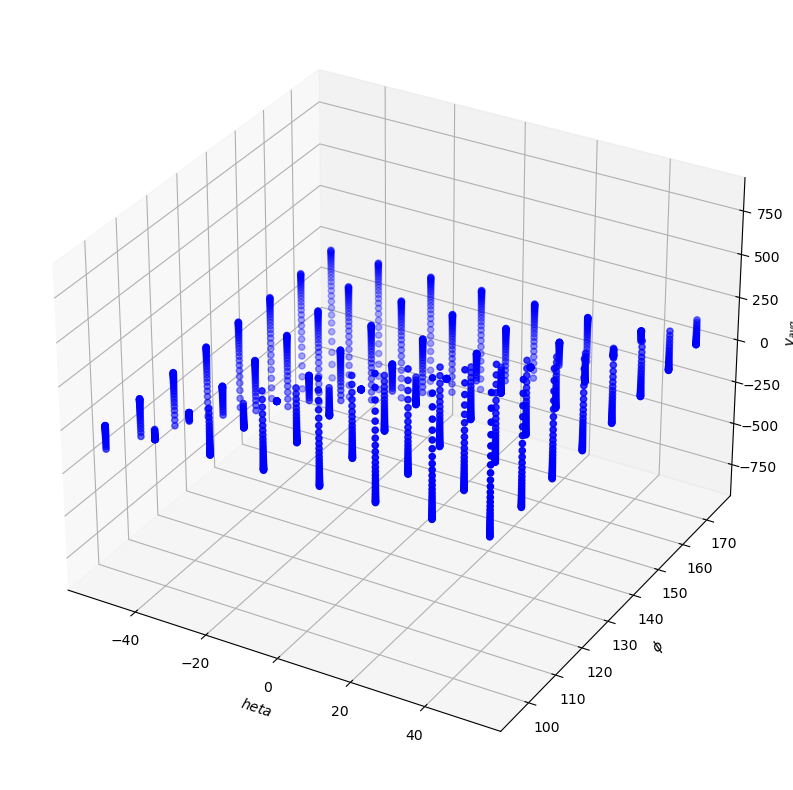

In [72]:
# Create a 3D plot of theta v. phi v. velocity
fig = plt.figure(figsize=[10, 10])
ax = fig.add_subplot(111, projection='3d')
# Plot the 3D surface
for i in range(0, 32):
    x = thetaReshaped[:, i, :]
    y = phiReshaped[:, i, :]
    z = mean_vel_arr[i, :, :]
    ax.scatter(x, y, z, c='b', marker='o', label='Points', zorder=1)
# Add labels
ax.set_xlabel('$\theta$')
ax.set_ylabel('$\phi$')
ax.set_zlabel('$v_{avg}$')



## Plotting

[186.8254]


Text(0.5, 0, 'Velocity (km/s)')

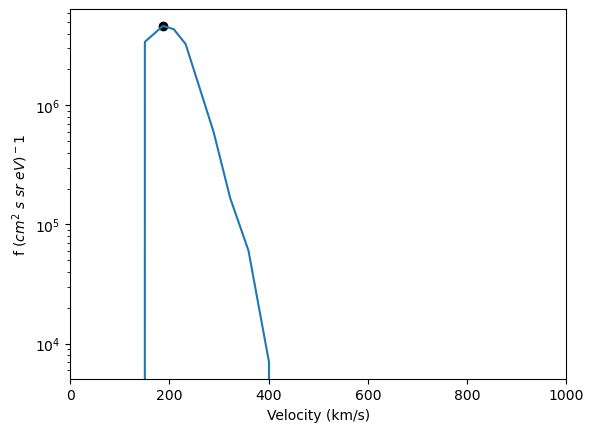

In [30]:
#sum over both phi and theta 
vdf_allAngles = np.sum(vdf, axis=(0,2))
mean_vel = vel[0, :, 0][np.where(vdf_allAngles == np.nanmax(vdf_allAngles))[0]]
print(mean_vel)

#plot and set limits/labels
plt.plot(vel[0,:,0],vdf_allAngles)
plt.scatter(mean_vel, np.nanmax(vdf_allAngles), c='k')
plt.yscale('log')
plt.xlim(0,1000)
plt.ylabel(f'f $(cm^2 \\ s \\ sr \\ eV)^{-1}$')
plt.xlabel('Velocity (km/s)')



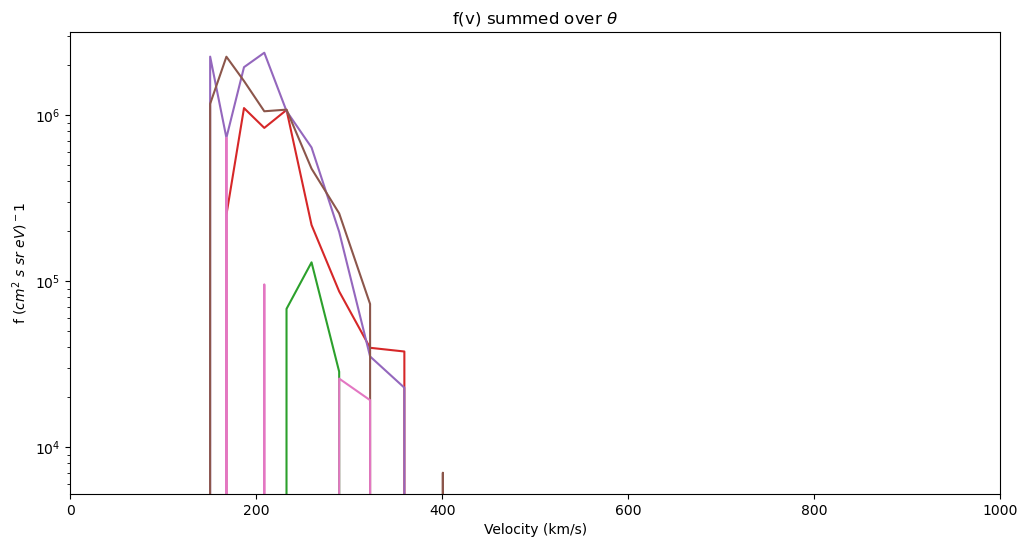

In [15]:
vdf_allThetas = np.sum(vdf, axis=0)
fig = plt.figure(figsize=(12, 6))
ax = fig.add_subplot(111)
ax.plot(vel[0,:,:],vdf_allThetas)

ax.set(xlim=(0, 1000),yscale='log', xlabel='Velocity (km/s)', ylabel=f'f $(cm^2 \\ s \\ sr \\ eV)^{-1}$',title='f(v) summed over $\\theta$');

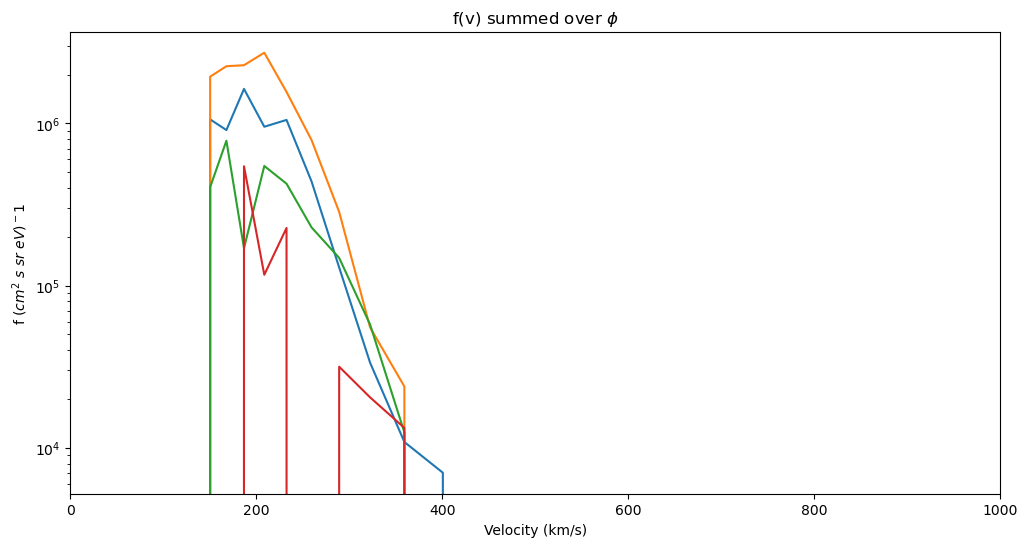

In [16]:
vdf_allPhis = np.sum(vdf, axis=2)
fig = plt.figure(figsize=(12, 6))
ax = fig.add_subplot(111)
ax.plot(np.transpose(vel[:,:,0]),np.transpose(vdf_allPhis))

ax.set(xlim=(0, 1000),yscale='log', xlabel='Velocity (km/s)', ylabel=f'f $(cm^2 \\ s \\ sr \\ eV)^{-1}$',title='f(v) summed over $\phi$');


Text(0.5, 1.0, 'VDF SPAN-I $\\theta$-plane')

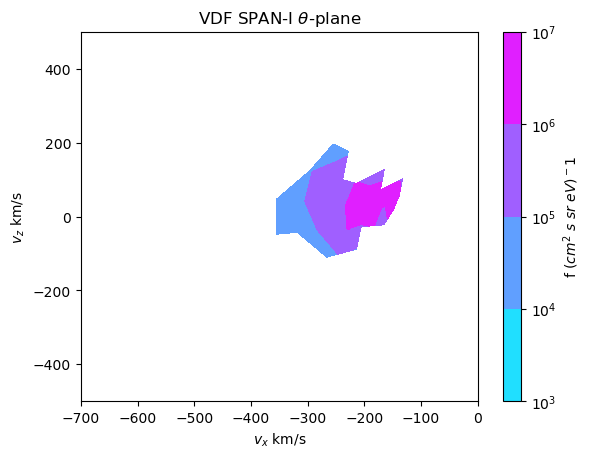

In [18]:
#theta is along dimension 0, while phi is along 2
#first cut through theta
theta_cut=0 

phi_plane = phiReshaped[theta_cut,:,:]
theta_plane = thetaReshaped[theta_cut,:,:]
energy_plane = energyReshaped[theta_cut,:,:]
vel_plane = np.sqrt(2*charge_p*energy_plane/mass_p)

df_theta=np.nansum(vdf,axis=0)

vx_plane_theta = vel_plane * np.cos(np.radians(phi_plane)) * np.cos(np.radians(theta_plane))
vy_plane_theta = vel_plane * np.sin(np.radians(phi_plane)) * np.cos(np.radians(theta_plane))
vz_plane_theta = vel_plane *                                   np.sin(np.radians(theta_plane))

fig,ax=plt.subplots()
cs=ax.contourf(vx_plane_theta, vz_plane_theta, df_theta,locator=ticker.LogLocator(),cmap=cm.cool)
cbar = fig.colorbar(cs)
cbar.set_label(f'f $(cm^2 \\ s \\ sr \\ eV)^{-1}$')

ax.set_xlim(-700,0)
ax.set_ylim(-500,500)
ax.set_xlabel('$v_x$ km/s')
ax.set_ylabel('$v_z$ km/s')
ax.set_title('VDF SPAN-I $\\theta$-plane')

Text(0.5, 1.0, 'VDF SPAN-I $\\phi$-plane')

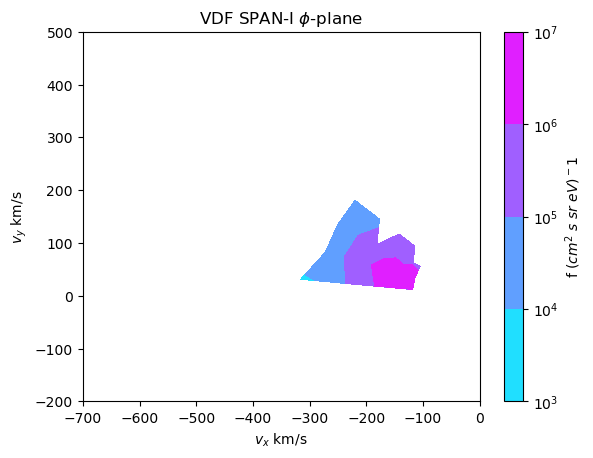

In [17]:
#now repeat for phi dimension
phi_cut = 1

phi_plane = phiReshaped[:,:,phi_cut]
theta_plane = thetaReshaped[:,:,phi_cut]
energy_plane = energyReshaped[:,:,phi_cut]
vel_plane = np.sqrt(2*charge_p*energy_plane/mass_p)

df_phi=np.nansum(vdf,axis=2)

vx_plane_phi = vel_plane * np.cos(np.radians(phi_plane)) * np.cos(np.radians(theta_plane))
vy_plane_phi = vel_plane * np.sin(np.radians(phi_plane)) * np.cos(np.radians(theta_plane))
vz_plane_phi = vel_plane *                                   np.sin(np.radians(theta_plane))

fig,ax=plt.subplots()
cs=ax.contourf(np.transpose(vx_plane_phi), np.transpose(vy_plane_phi), np.transpose(df_phi),locator=ticker.LogLocator(),cmap=cm.cool)
cbar = fig.colorbar(cs)
cbar.set_label(f'f $(cm^2 \\ s \\ sr \\ eV)^{-1}$')

ax.set_xlim(-700,0)
ax.set_ylim(-200,500)
ax.set_xlabel('$v_x$ km/s')
ax.set_ylabel('$v_y$ km/s')
ax.set_title('VDF SPAN-I $\\phi$-plane')